# Offline Phase: PBDW offline - computing the inf-sup constant

**Aim of the tutorial:** this notebook shows how to calculate the $inf-sup$ constant, bounding the approximation error of the PBDW.

----

*To execute this notebook* it is necessary to have the POD modes stored in `Offline_results/BasisFunctions` folder, placed in this directory (otherwise modify `path_off` variable) and the basis sensors in `Offline_results/BasisSensors`.

In [1]:
import numpy as np
from IPython.display import clear_output

from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store

import matplotlib.pyplot as plt
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
from neutronics import create_anl11a2_mesh

domain, _, _ = create_anl11a2_mesh(use_msh=True, save_mesh=False)

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

clear_output()

## Importing basis function and sensors

The functional space and the names of the fields are defined.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

Let us import the POD modes using `ImportH5`.

In [4]:
bf = dict()

for field_i in range(len(var_names)):
    
    bf[var_names[field_i]] = ImportH5(V, path_off+'/BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]

Let us import the basis sensors generated with SGREEDY.

In [5]:
s = 2

is_H1 = [False, True]
fun_space_label = ['L2', 'H1']

bs = dict()

for field in var_names:
    bs[field] = dict()
    for space in fun_space_label:
            bs[field][space] = ImportH5(V, 
                                        path_off+'/BasisSensors/sensorsSGREEDYPOD_' + field+'_s_{:.2e}_'.format(s)+space,
                                        'SGREEDYPOD_' +field+'_s_{:.2e}'.format(s))[0]

## PBDW-Offline: Compute the *inf-sup* constant
The *inf-sup* constant is a measure of the approximation capabilities of the PBDW, in particular highlights how the sensors are able to include more information into the background model, encoded in the basis functions. The *inf-sup* constant is computed by solving an eigenvalue problem, as reported in [Maday and Taddei (2019)](https://epubs.siam.org/doi/10.1137/18M116544X).

Given the background space $Z_N = \text{span}\{\zeta_1, \zeta_2, \dots, \zeta_N\}$, spanned by the POD modes, and the update space $\mathcal{U}_M=\text{span}\{g_1, g_2, \dots, g_M\}$, spanned by the sensors selected by SGREEDY, the following matrices can be defined
\begin{equation*}
A_{mm'} = \left(g_m, g_{m'}\right)_{\mathcal{U}}\qquad
K_{mn} = \left(g_m, \zeta_{n}\right)_{\mathcal{U}} = v_m(\zeta_n)\qquad
B_{nn'} = \left(\zeta_n, \zeta_{n'}\right)_{\mathcal{U}}
\end{equation*}
The *inf-sup* constant $\beta_{N,M}$ is the square-root of the minimum eigenvalue of the following problem
\begin{equation*}
K^TA^{-1}K \mathbf{w}_j = \lambda_j B\mathbf{w}_j
\end{equation*}
that is $\beta_{N,M} = \sqrt{\min\limits_{j=1,\dots, N} \lambda_j}$.

This eigenvalue problem can be solved using the `PBDW` offline class, using the method `compute_infsup`. This class must be initialised with the basis functions, the basis sensors and the flag for the Riesz representation, either $L^2$ or $H^1$.

To compute the *inf-sup* constant the dimension of the reduced space must be fixed, a good approximation of the manifold can be reached with $N=10$, obtained by observabing the POD eigenvalues.

In [6]:
from pyforce.offline.pbdw import PBDW

Nmax = 10
Mmax = 20

inf_sup_constants = dict()

for field in var_names:
    inf_sup_constants[field] = dict()
    
    inf_sup_constants[field]['s = {:.2f}'.format(s)] = dict()
    for kk, space in enumerate(fun_space_label):
        
        print('Compute Inf-Sup for '+field+' with s={:.2f}'.format(s)+' and Riesz representation in '+space)
        
        pbdw = PBDW(bf[field], bs[field][space], is_H1[kk])
        inf_sup_constants[field]['s = {:.2f}'.format(s)][space] = pbdw.compute_infsup(Nmax, Mmax)
        
        del pbdw

Compute Inf-Sup for phi_1 with s=2.00 and Riesz representation in L2
Compute Inf-Sup for phi_1 with s=2.00 and Riesz representation in H1
Compute Inf-Sup for phi_2 with s=2.00 and Riesz representation in L2
Compute Inf-Sup for phi_2 with s=2.00 and Riesz representation in H1


Let us plot the constant for the different configurations.

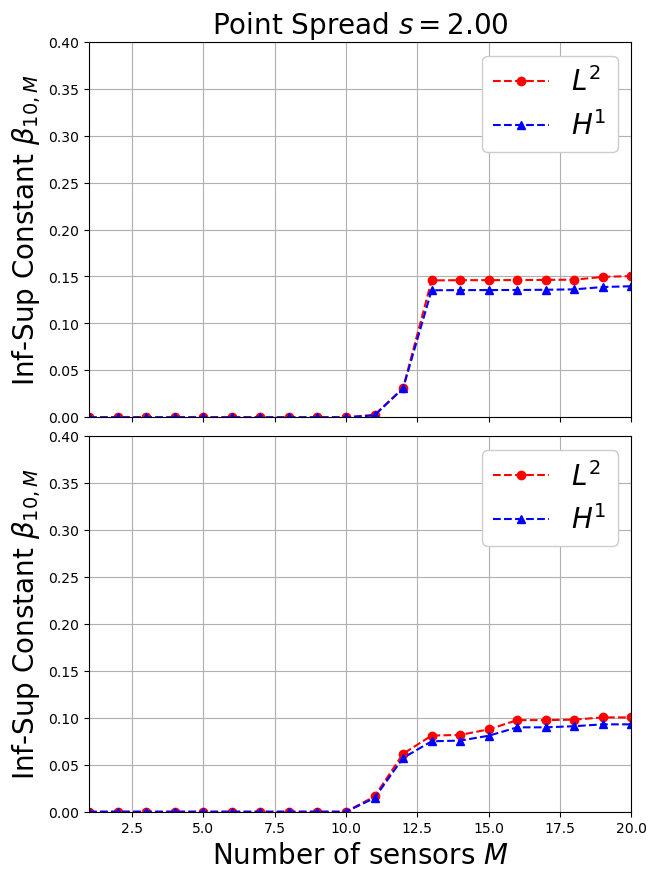

In [7]:
fig, axs = plt.subplots(nrows = len(var_names), ncols = 1, sharey=True, sharex=True, figsize = (7, 5 * len(var_names)))

Mplot = np.arange(1, Mmax + 1, 1)

for field_i, field in enumerate(var_names):
    
    axs[field_i].plot(Mplot, inf_sup_constants[field]['s = {:.2f}'.format(s)]['L2'], 
                            '--o', c='r', label=r'$L^2$')
    axs[field_i].plot(Mplot, inf_sup_constants[field]['s = {:.2f}'.format(s)]['H1'], 
                            '--^', c='b', label=r'$H^1$')
    
    axs[field_i].set_ylim(0, 0.4)
    axs[field_i].set_xlim(1, Mmax)
    axs[field_i].grid()
    axs[field_i].legend(framealpha=1, fontsize=20)
    
    axs[0,].set_title(r'Point Spread $s={:.2f}$'.format(s), fontsize=20)
    axs[-1].set_xlabel(r'Number of sensors $M$', fontsize=20)
        
    axs[field_i].set_ylabel(r'Inf-Sup Constant $\beta_{10,M}$', fontsize=20)

fig.subplots_adjust(hspace=0.05, wspace=0.025)